<a href="https://colab.research.google.com/github/LuanLucasFS/AiModels/blob/main/NumberRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[1] Importação de Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

Função: Importa todas as bibliotecas necessárias.

Detalhes:

* pandas/numpy: Manipulação de dados

* matplotlib/seaborn: Visualizações gráficas

* cv2: Processamento de imagens

* sklearn: Algoritmos de ML (KNN) e métricas

* tensorflow.keras: Construção de redes neurais

* google.colab: Upload de arquivos no Colab.

#[2] Carregamento dos Dados

In [4]:
# Carregando os dados
data = pd.read_csv('/content/sample_data/train.csv')
x, y = data.drop(['label'], axis=1).values, data['label'].values

Função: Carrega o dataset MNIST (dígitos manuscritos).

Detalhes:

* x: Features (pixels das imagens 28x28 achatados em vetores de 784 elementos).

* y: Labels (números de 0 a 9).

#[3] Normalização

In [5]:
# Normalização dos dados (0 a 1)
x = x / 255.0

Função: Escala os valores dos pixels para o intervalo [0, 1].

Por quê? Valores entre 0 e 1 aceleram o treinamento e melhoram o desempenho do modelo.

#[4] Divisão dos Dados

In [6]:
# Divisão dos dados
test_size = 42000 - 38000  # 4.000 exemplos para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

Função: Divide os dados em treino (38.000 amostras) e teste (4.000 amostras).

Detalhes:

* random_state=42: Garante reprodutibilidade na divisão.

#[5] Imputação de Valores Ausentes

In [7]:
# Imputação para tratar valores ausentes
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

Função: Preenche valores faltantes (se existirem) com a média das features.

Observação: MNIST geralmente não tem valores ausentes, mas é uma boa prática preventiva.

#[6] Busca do Melhor k para KNN

In [8]:
# Ajuste do k no KNN
def find_best_k():
    k_values = range(1, 21)
    scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k), x_train, y_train, cv=5).mean() for k in k_values]
    best_k = k_values[np.argmax(scores)]
    return best_k

Função: Encontra o k ideal para KNN via validação cruzada (k com maior acurácia).

In [12]:
best_k = find_best_k()
print(f'Melhor valor de k: {best_k}')

Melhor valor de k: 1


#[7] Treinamento e Avaliação do KNN

In [13]:
# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)
preds_knn = knn.predict(x_test)
print(f'Acurácia do KNN: {accuracy_score(y_test, preds_knn)}')
print(f'Matriz de Confusão do KNN:\n{confusion_matrix(y_test, preds_knn)}')

Acurácia do KNN: 0.939
Matriz de Confusão do KNN:
[[384   0   1   0   0   2   4   0   0   0]
 [  0 420   1   2   0   1   3   2   0   1]
 [  3  10 400   5   3   1   0  10   4   3]
 [  1   2   3 368   0   7   0   1   4   2]
 [  0   5   0   0 374   0   1   0   0  18]
 [  1   1   0   7   0 349   4   0   0   6]
 [  3   0   0   0   3   1 390   0   0   1]
 [  0   3   6   1   2   0   0 382   0   9]
 [  5   7   1  13   1  14   4   1 335   8]
 [  1   3   2   1  16   3   1  14   1 354]]


Saídas:

* Acurácia: Porcentagem de acertos.

* Matriz de Confusão: Comparação entre previsões e valores reais.



#[8] One-Hot Encoding

In [14]:
# One-hot encoding das saídas
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Função: Converte labels numéricos em vetores binários (ex.: 2 → [0,0,1,0,...,0]).

Por quê? Necessário para redes neurais com saída multiclasse.

#[9] Arquitetura da Rede Neural

In [15]:
# Modelo de Rede Neural
model = Sequential()
model.add(Dense(128, input_shape=(x_train.shape[1],)))
model.add(LeakyReLU(negative_slope=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64))
model.add(LeakyReLU(negative_slope=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32))
model.add(LeakyReLU(negative_slope=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Detalhes:

* 3 camadas ocultas com regularização (Dropout + BatchNorm).

* LeakyReLU: Versão da ReLU que evita "neurônios mortos".

* softmax: Saída probabilística para 10 classes.

#[10] Early Stopping

In [16]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Função: Interrompe o treinamento se a perda de validação não melhorar em 10 épocas.

Vantagem: Evita overfitting e economiza tempo.

#[11] Treinamento da Rede

In [17]:
# Treinamento
model.fit(x_train, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=2)

Epoch 1/200
144/144 - 10s - 70ms/step - accuracy: 0.5398 - loss: 1.4536 - val_accuracy: 0.8094 - val_loss: 0.9367
Epoch 2/200
144/144 - 1s - 5ms/step - accuracy: 0.7590 - loss: 0.7844 - val_accuracy: 0.8938 - val_loss: 0.4341
Epoch 3/200
144/144 - 1s - 9ms/step - accuracy: 0.8226 - loss: 0.6063 - val_accuracy: 0.9182 - val_loss: 0.3276
Epoch 4/200
144/144 - 1s - 9ms/step - accuracy: 0.8592 - loss: 0.4980 - val_accuracy: 0.9295 - val_loss: 0.2607
Epoch 5/200
144/144 - 1s - 6ms/step - accuracy: 0.8742 - loss: 0.4308 - val_accuracy: 0.9312 - val_loss: 0.2527
Epoch 6/200
144/144 - 1s - 9ms/step - accuracy: 0.8894 - loss: 0.3898 - val_accuracy: 0.9391 - val_loss: 0.2296
Epoch 7/200
144/144 - 2s - 14ms/step - accuracy: 0.8999 - loss: 0.3496 - val_accuracy: 0.9330 - val_loss: 0.2307
Epoch 8/200
144/144 - 1s - 6ms/step - accuracy: 0.9155 - loss: 0.2993 - val_accuracy: 0.9408 - val_loss: 0.2156
Epoch 9/200
144/144 - 1s - 8ms/step - accuracy: 0.9123 - loss: 0.2923 - val_accuracy: 0.9426 - val_lo

Detalhes:

* validation_split=0.2: 20% dos dados de treino são usados para validação.

* batch_size=32: Atualiza os pesos a cada 32 amostras.

#[12] Avaliação da Rede Neural

In [18]:
# Avaliação
eval_results = model.evaluate(x_test, y_test)
print(f'Acurácia da Rede Neural: {eval_results[1]}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.2293
Acurácia da Rede Neural: 0.937250018119812


Saída: Mostra a acurácia final no conjunto de teste.

#[13] Teste com Imagens Individuais

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


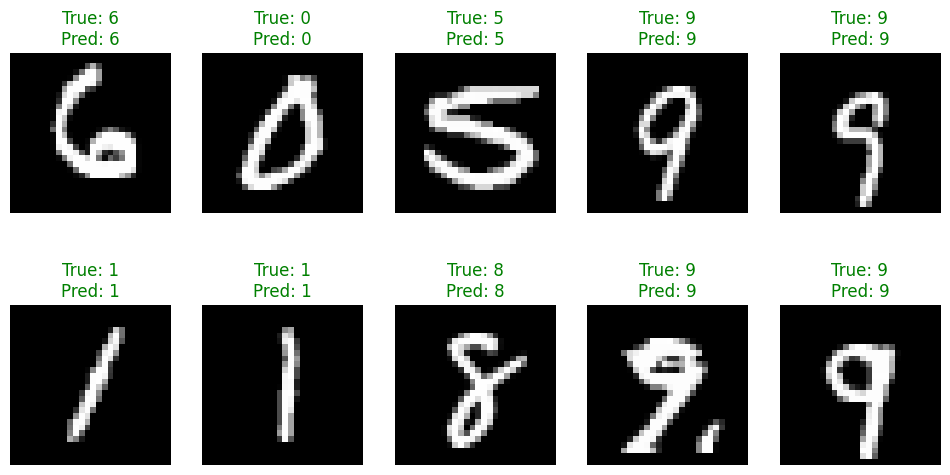

In [19]:
# Teste com imagens individuais
num_test_samples = 10
indices = np.random.choice(len(x_test), num_test_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    img = x_test[idx].reshape(28, 28)
    true_label = np.argmax(y_test[idx])
    pred_label = np.argmax(model.predict(x_test[idx].reshape(1, -1)))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {true_label}\nPred: {pred_label}', color='green' if true_label == pred_label else 'red')
    plt.axis('off')
plt.show()

Função: Seleciona 10 imagens aleatórias do teste, mostra a imagem com rótulo real e previsto.
Cores:

* Verde: Acerto

* Vermelho: Erro

#[14] Matriz de Confusão

In [ ]:
# Matriz de Confusão
preds_nn = model.predict(x_test)
preds_nn_labels = np.argmax(preds_nn, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_labels, preds_nn_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Rede Neural')
plt.show()

Função: Mostra quantas vezes cada classe foi classificada corretamente ou confundida com outras.

#[15] Relatório de Classificação

In [ ]:
# Relatório de Classificação
print('Relatório de Classificação - Rede Neural:\n', classification_report(y_test_labels, preds_nn_labels))

Saída: Exibe precisão, recall e F1-score para cada classe (0-9).

#[16-19] Teste com Imagem Personalizada

Saving Sem título2.png to Sem título2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
O modelo previu: 5


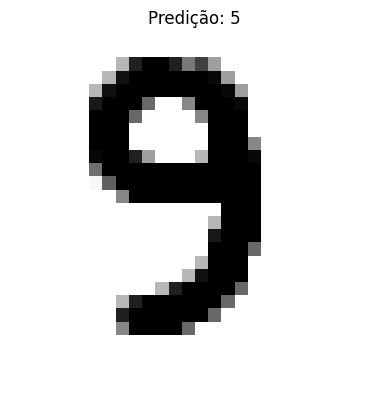

In [ ]:
# Carregar imagem personalizada para teste
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Ler em escala de cinza
    img = cv2.resize(img, (28, 28))  # Redimensionar para 28x28 pixels
    img = img / 255.0  # Normalizar os pixels para faixa 0-1
    img = img.reshape(1, -1)  # Achatar para um vetor de entrada
    return img

# Pré-processar a imagem
img = preprocess_image(image_path)

# Fazer a previsão
prediction = np.argmax(model.predict(img))
print(f'O modelo previu: {prediction}')

# Exibir a imagem carregada
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title(f'Predição: {prediction}')
plt.axis('off')
plt.show()


Passos:

Faz upload de uma imagem do seu computador.

Pré-processa (redimensiona, normaliza e achata).

Faz a predição e exibe o resultado.

#[20] Carregar e Processar o test.csv

In [21]:
# Carregar o arquivo de teste
test_data = pd.read_csv('/content/sample_data/test.csv')

# Extrair os dados (não há coluna 'label')
x_test_new = test_data.values

# Aplicar as mesmas transformações do treino
x_test_new = x_test_new / 255.0  # Normalização
x_test_new = imputer.transform(x_test_new)  # Usar o mesmo imputer treinado

Detalhes:

* O arquivo test.csv contém apenas as features (pixels), sem labels.

* Aplicamos a mesma normalização (/255.0) e imputação usadas nos dados de treino.

#[21] Fazer Previsões com a Rede Neural

In [22]:
# Fazer previsões
preds_nn_new = model.predict(x_test_new)
preds_nn_labels = np.argmax(preds_nn_new, axis=1)  # Converter one-hot para labels

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Saída:

* preds_nn_labels: Array com as previsões (números entre 0 e 9).

#[22] Criar Arquivo de Submissão (Formato Competição)

In [23]:
# Criar DataFrame para submissão
submission = pd.DataFrame({
    'ImageId': range(1, len(preds_nn_labels) + 1),  # IDs começam em 1
    'Label': preds_nn_labels
})

# Salvar e fazer download
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')  # Download automático no Colab

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Formato do Arquivo:

ImageId |	Label
--------|-------
1	| 2
2	| 0
...	| ...


#[23] Visualizar Previsões (Opcional)

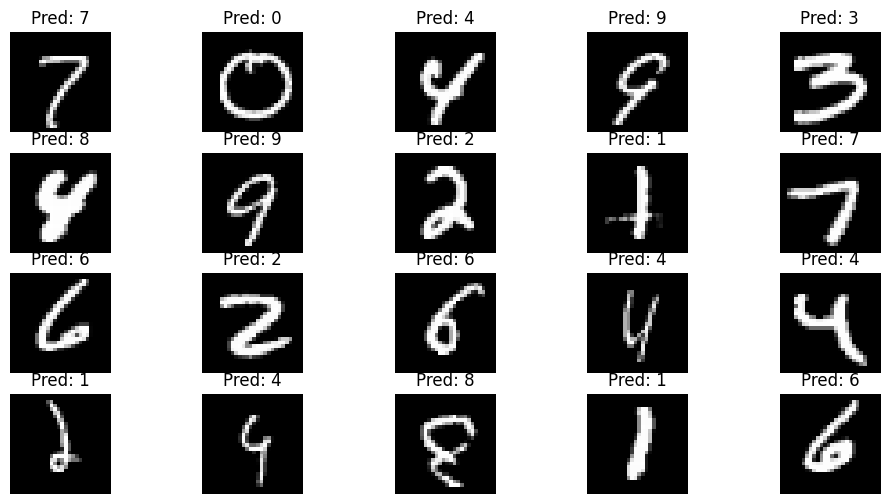

In [28]:
# Visualizar x imagens aleatórias com previsões
plt.figure(figsize=(12, 6))
tests = 20
indices = np.random.choice(len(x_test_new), tests, replace=False)

# Change subplot layout to accommodate 20 plots
for i, idx in enumerate(indices):
    img = x_test_new[idx].reshape(28, 28)
    pred_label = preds_nn_labels[idx]

    rows = int(tests/5)
    # Use 4 rows and 5 columns to accommodate 20 subplots
    plt.subplot(rows, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: {pred_label}')
    plt.axis('off')

plt.show()

Saída:
* Gráfico com 10 imagens do test.csv e as previsões do modelo.